In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant

In [35]:
n_cores = 28

spark = (
    SparkSession.builder
    .master(f"local[{n_cores}]")
    .appName("Saturation")
    .config("spark.sql.shuffle.partitions", "500")
    .config("spark.driver.memory", "40g")
    .config("spark.driver.maxResultSize", "8g")
    .getOrCreate()
)

In [36]:
base_path = "/data/saturation/thesis_run_20250213/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_df = create_configs_df(
    read_configs(
        base_path,
        spark,
        completed_only=False
    )
)
configs_pdf = configs_df.toPandas()

configs_pdf = configs_pdf[~configs_pdf.simulation_id.isna()].copy()
configs_pdf["rim_erasure_exponent"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("exponent", -1))
configs_pdf["rim_erasure_radius_ratio"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("ratio", -1))
configs_pdf["nstop"] = configs_pdf.stop_condition.apply(lambda x: x.get("ntot", -1))

In [37]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

In [38]:
configs_pdf[configs_pdf.slope.between(-4.6, -4.4)]

,mrp,rim_erasure_method,rmin,rmult,simulation_id,slope,stop_condition,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio,nstop
8,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.1}",0.37,1.0,18,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.1,3.0,-1
22,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.4}",0.37,1.0,63,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.4,3.0,-1
63,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.3}",0.37,1.0,48,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.3,3.0,-1
77,0.5,"{'name': None, 'ratio': 1000000.0, 'exponent':...",1.00,1.0,3,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,1000000.0,-1
88,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 1.0}",1.00,1.0,1,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,3.0,-1
104,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 1.0}",0.37,1.0,153,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,3.0,-1
105,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.9}",0.37,1.0,138,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.9,3.0,-1
112,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.7}",0.37,1.0,108,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.7,3.0,-1
128,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.2}",0.37,1.0,33,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.2,3.0,-1
143,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.5}",0.37,1.0,78,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.5,3.0,-1


In [39]:
df = get_statistics_with_lifespans_for_simulations(
    simulation_ids=[1],
    base_path=base_path,
    configs_df=configs_df,
    spark=spark,
    n_samples_per_sim=1000000
)
df

,x,y,radius,simulation_id,nstat,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,1750.704989,1094.270181,3.766048,1,1,1,0.000011,-4.5,0.5,1.0,NaN,3.0,1.0,1352005.0
1,1755.441322,2108.775008,3.256511,1,2,2,0.000019,-4.5,0.5,1.0,NaN,3.0,1.0,1198054.0
2,2245.076938,390.710247,4.054762,1,4,4,0.000051,-4.5,0.5,1.0,NaN,3.0,1.0,714994.0
3,485.460812,1201.734623,3.315666,1,5,5,0.000060,-4.5,0.5,1.0,NaN,3.0,1.0,616108.0
4,971.507380,1900.612375,5.434638,1,6,6,0.000082,-4.5,0.5,1.0,NaN,3.0,1.0,4651851.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2103.459378,405.604459,3.546601,1,1874993,8183,0.275089,-4.5,0.5,1.0,NaN,3.0,1.0,432237.0
999996,1619.081513,778.428942,3.173184,1,1874994,8182,0.275081,-4.5,0.5,1.0,NaN,3.0,1.0,510526.0
999997,835.951279,716.840515,3.430948,1,1874996,8182,0.275073,-4.5,0.5,1.0,NaN,3.0,1.0,769103.0
999998,1482.735866,1232.655543,6.208613,1,1874997,8183,0.275103,-4.5,0.5,1.0,NaN,3.0,1.0,9092982.0


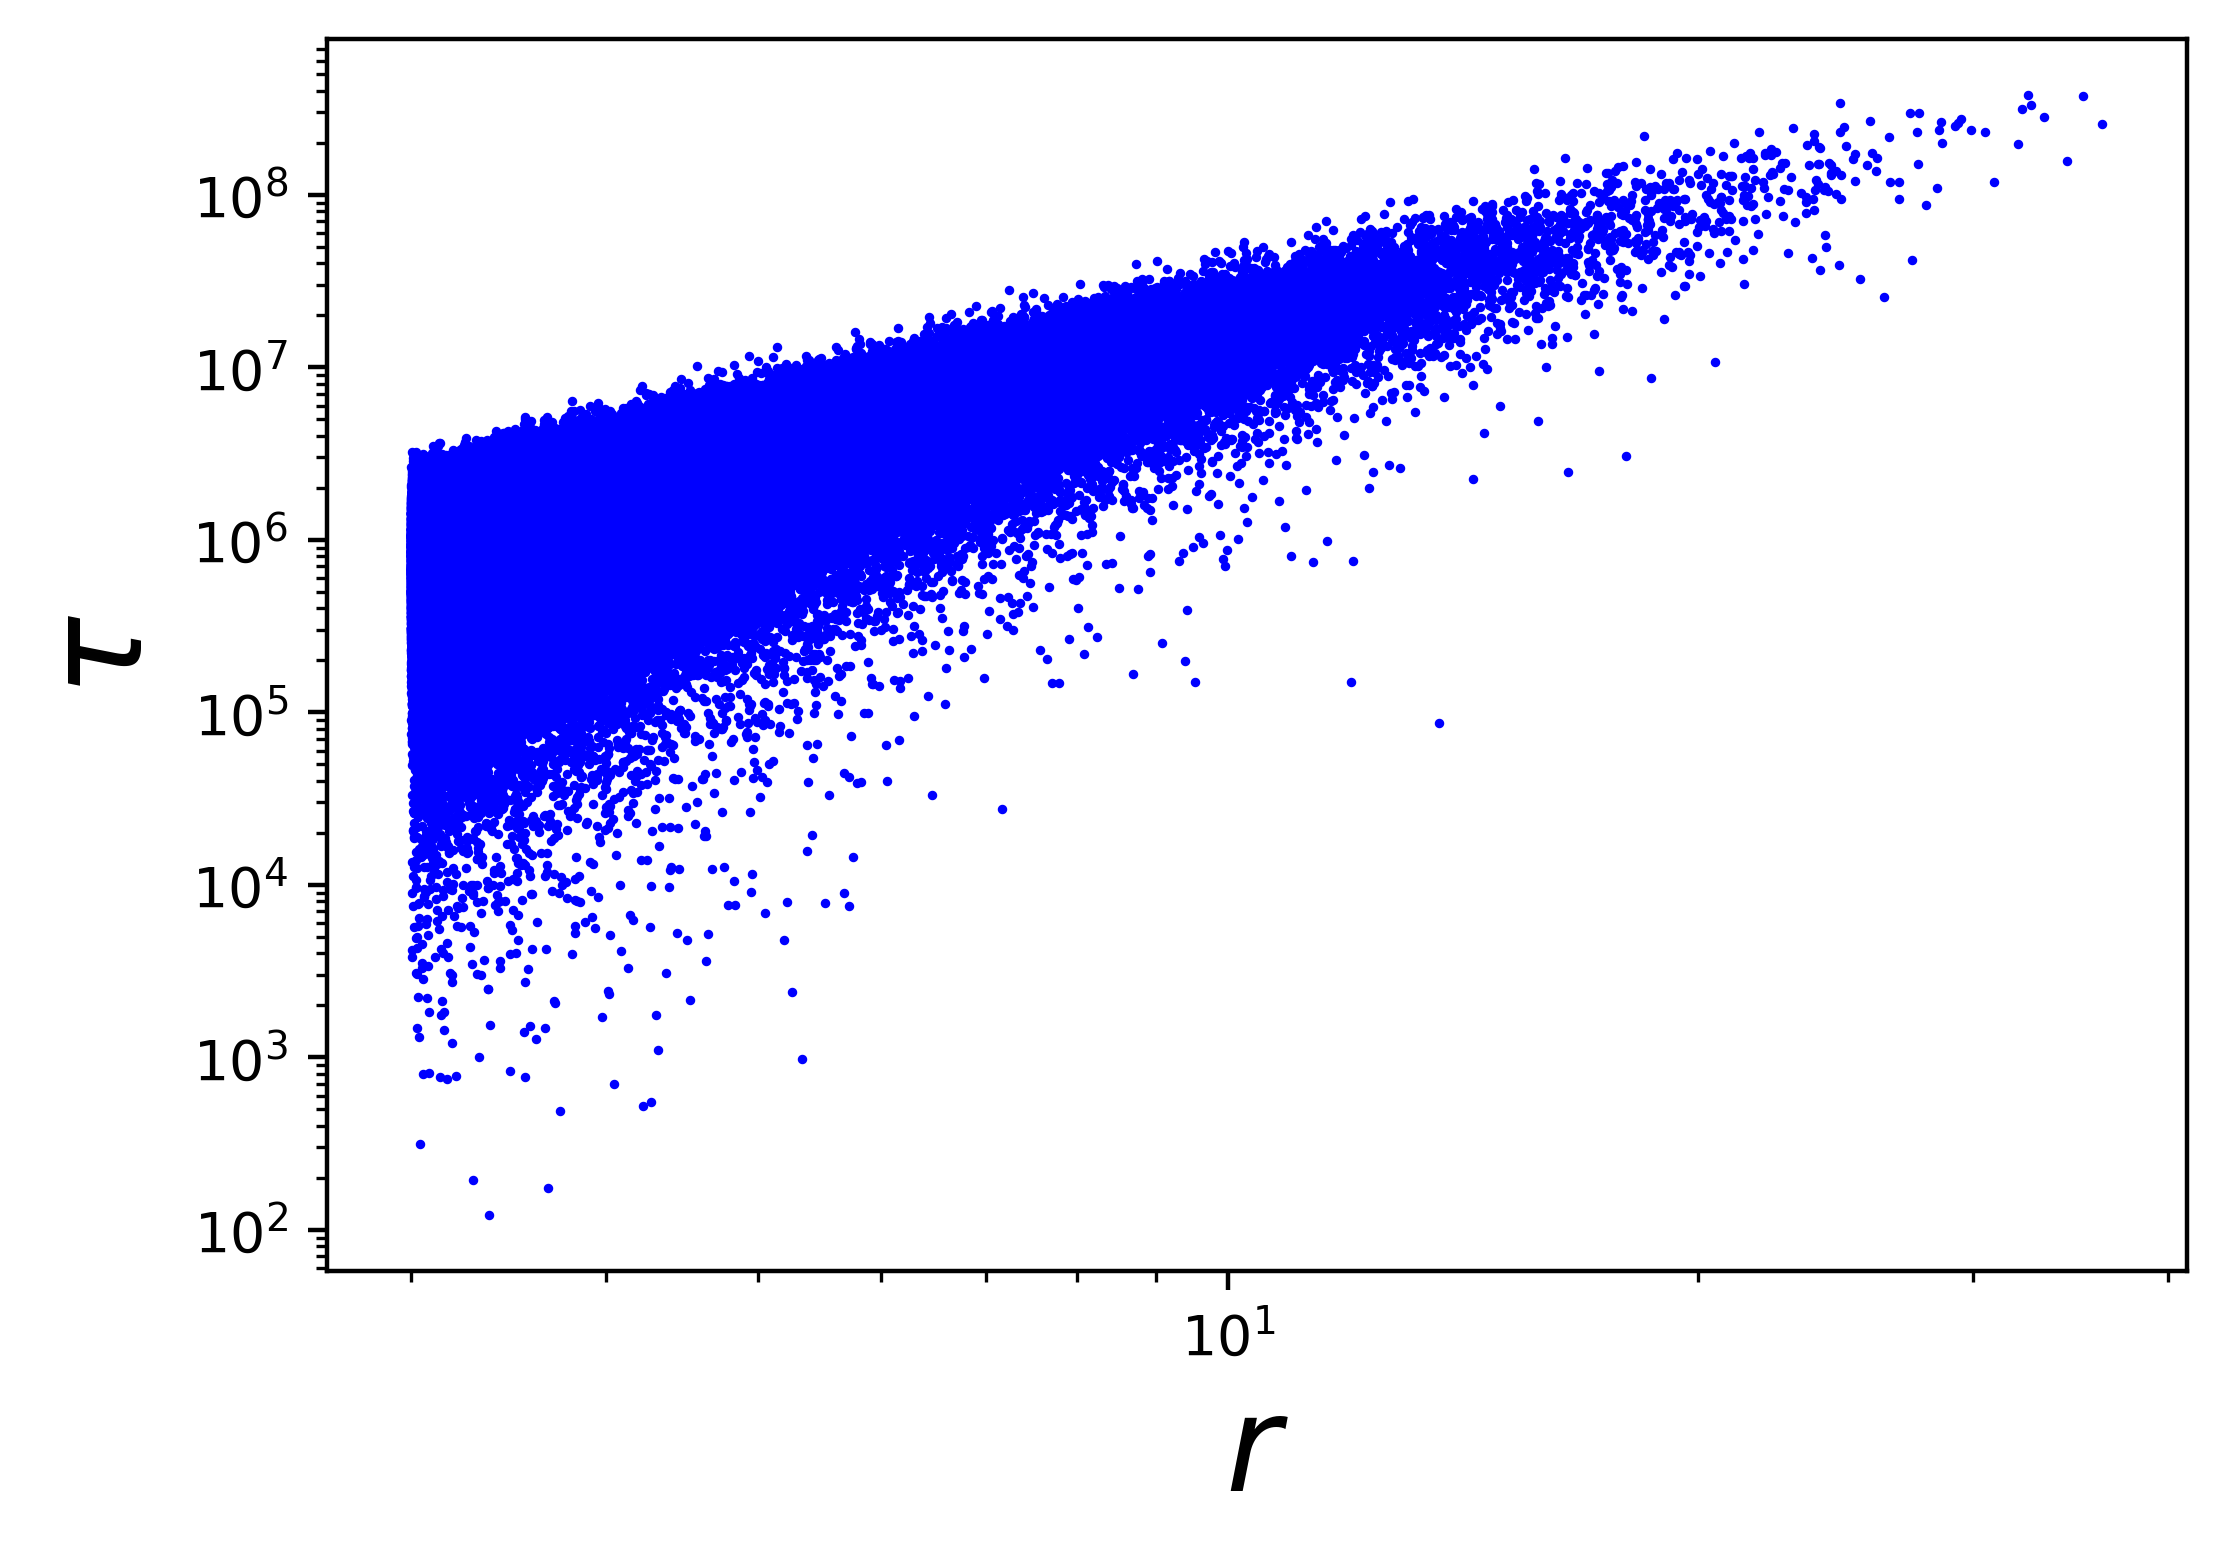

In [42]:
plt.figure(figsize=(6, 4), dpi=dpi)

# Sampled scatterplot
plt.scatter(
    df.radius,
    df.lifespan,
    c="blue",
    s=.5,
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$r$", fontsize=font_size)
plt.ylabel(fr"$\tau$", fontsize=font_size)

plt.savefig(f"figures/example_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [43]:
model = smf.negativebinomial(data=df, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="BFGS", cov_type="HC0")
print(model.summary())

Optimization terminated successfully.
         Current function value: 14.737818
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:               999967
Model:               NegativeBinomial   Df Residuals:                   999965
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Feb 2025   Pseudo R-squ.:                 0.03929
Time:                        19:35:29   Log-Likelihood:            -1.4737e+07
converged:                       True   LL-Null:                   -1.5340e+07
Covariance Type:                  HC0   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.8458     

In [44]:
# Dispersion statistic
np.sum(model.resid_pearson**2) / model.df_resid

0.9180557942226907